In [2]:
import json
import pandas as pd
import gzip
import sys
sys.path.append('../src')
from utils import *
import numpy as np

In [80]:

meta = getDF('../../project/meta_Sports_and_Outdoors.json', save=False)
df = pd.read_csv('../../project/Sports_and_Outdoors_5_2016_2018.csv')

In [81]:
meta['price'] = meta['price'].str.replace('$', '')
meta['price'] = meta['price'].replace('nan', 0).replace('', 0)
meta['price'] = meta['price'].apply(pd.to_numeric, errors='coerce').fillna(0)

meta['also_buy'] = meta['also_buy'].fillna('[]').apply(lambda x: len(x))
meta['also_view'] = meta['also_view'].fillna('[]').apply(lambda x: len(x))

meta = meta.drop(['tech2', 'tech1', 'fit', 'date', 'details', 'imageURL', 'imageURLHighRes', 'rank', 'similar_item', 'description', 'feature'], axis=1)

C:\Users\aurav\AppData\Local\Temp\ipykernel_14400\3759937403.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  meta['price'] = meta['price'].str.replace('$', '')


# group definition

g1<average order price, main category order,order frequency>

In [82]:
# count number of order for each reviewer
df = df.join(meta.set_index('asin'), on='asin')
df['nb_order'] = df.groupby('reviewerID')['reviewerID'].transform('count')
# make average price for each reviewer
df['avg_price'] = df.groupby('reviewerID')['price'].transform('mean')
df.head()

,overall,reviewTime,reviewerID,asin,reviewText,unixReviewTime,category,title,also_buy,brand,also_view,main_cat,price,nb_order,avg_price
0,5.0,2016-12-27,ASAE9FBGAJQAH,0899332757,Arrived on time. Nice Atlas - Easy to read.,1482796800,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,11,21.160909
1,3.0,2016-12-12,A1TAW91SQSU2AH,0899332757,More of a road map than a useful topographical...,1481500800,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,4,9.585000
2,5.0,2016-08-13,A1SVGO4GMEOXQ0,0899332757,Comprehensive atlas. Very happy with how much ...,1471046400,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,4,9.065000
3,5.0,2016-08-02,A36QT6N7N0GF3O,0899332757,Delorme has always made the best book maps in ...,1470096000,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,7,10.232857
4,5.0,2016-07-14,AJGZDX7KC5TVQ,0899332757,worked great on the trip around ny,1468454400,"[Sports & Outdoors, Outdoor Recreation, Campin...",Delorme New York State Atlas &amp; Gazetteer,78.0,Garmin,38.0,Office Products,19.95,5,39.394000


In [83]:
# for each reviewer, count number of order by main_cat in a df2 who have just the reviewerID and the main_cat
df2 = df[['reviewerID', 'main_cat']]
#group by reviewerID and main_cat and count the number of order
df2 = df2.groupby(['reviewerID', 'main_cat']).size().reset_index(name='nb_order_main_cat')
df2 = df2.drop_duplicates()
df2 = df2.loc[df2.groupby('reviewerID')['nb_order_main_cat'].idxmax()]

df2 = df2.rename(columns={'main_cat':'main_cat2'})
df = df.join(df2.set_index('reviewerID'), on='reviewerID')
df1 = df[['reviewerID', 'nb_order', 'avg_price', 'main_cat2']] 
df1 = df1.rename(columns={'main_cat2':'main_cat'})

df1.head()

,reviewerID,nb_order,avg_price,main_cat
0,ASAE9FBGAJQAH,11,21.160909,Sports & Outdoors
1,A1TAW91SQSU2AH,4,9.585000,Sports & Outdoors
2,A1SVGO4GMEOXQ0,4,9.065000,Sports & Outdoors
3,A36QT6N7N0GF3O,7,10.232857,Sports & Outdoors
4,AJGZDX7KC5TVQ,5,39.394000,Tools & Home Improvement


<Axes: >

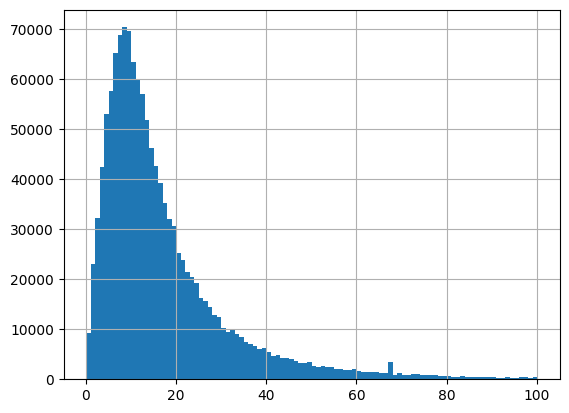

In [84]:
df1 = df1[df1['avg_price'] < 100]
df1 = df1[df1['avg_price'] > 0]
df1['avg_price'].hist(bins=100)

<Axes: >

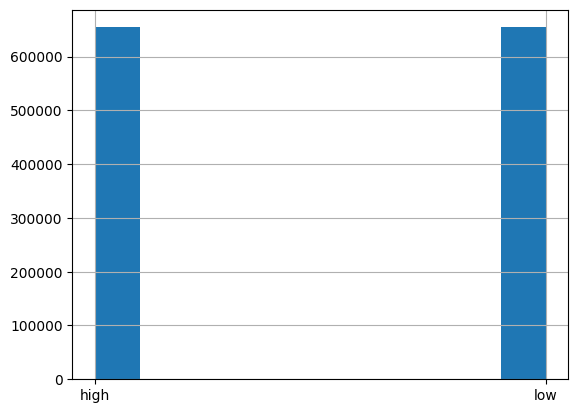

In [85]:
df1['spender'] = np.where(df1['avg_price'] > df1['avg_price'].median(), 'high', 'low')
df1['spender'].hist()

<Axes: >

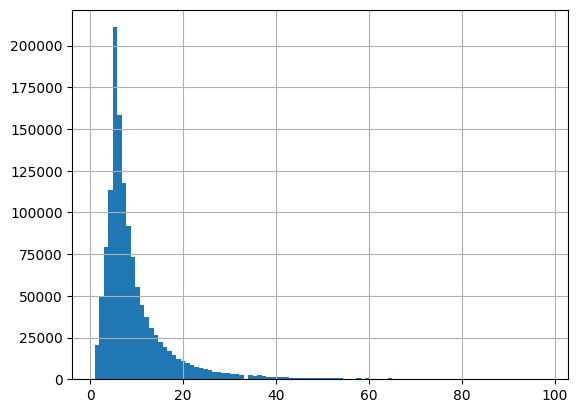

In [86]:
df1 = df1[df1['nb_order'] < 100]
df1['nb_order'].hist(bins=100)

<Axes: >

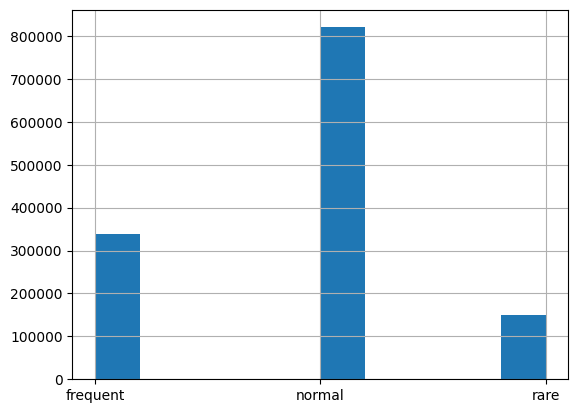

In [87]:
df1['order'] = np.where(df1['nb_order'] > 10, 'frequent', np.where(df1['nb_order'] > 3, 'normal', 'rare'))
df1['order'].hist()

In [88]:
df1['main_cat'] = df1['main_cat'].astype(str)
df1 = df1[~df1['main_cat'].str.startswith('<')]
df1['main_cat'].value_counts()

df2 = df[['reviewerID', 'overall']]
df2 = df2.groupby('reviewerID')['overall'].mean().reset_index()
df2 = df2.rename(columns={'overall':'avg_rating'})
df1 = df1.join(df2.set_index('reviewerID'), on='reviewerID')

In [89]:
df1['group'] = '<' + df1['order'] + ',' + df1['spender'] + ',' + df1['main_cat'] + '>'
df1.head()

,reviewerID,nb_order,avg_price,main_cat,spender,order,avg_rating,group
0,ASAE9FBGAJQAH,11,21.160909,Sports & Outdoors,high,frequent,4.272727,"<frequent,high,Sports & Outdoors>"
1,A1TAW91SQSU2AH,4,9.585000,Sports & Outdoors,low,normal,4.250000,"<normal,low,Sports & Outdoors>"
2,A1SVGO4GMEOXQ0,4,9.065000,Sports & Outdoors,low,normal,4.500000,"<normal,low,Sports & Outdoors>"
3,A36QT6N7N0GF3O,7,10.232857,Sports & Outdoors,low,normal,4.857143,"<normal,low,Sports & Outdoors>"
4,AJGZDX7KC5TVQ,5,39.394000,Tools & Home Improvement,high,normal,5.000000,"<normal,high,Tools & Home Improvement>"


In [90]:
# make a list with all different groups
groups = df1['group'].unique().tolist()
len(groups)

88

In [91]:
# compute the diversity of each group diversity(G, R) = 1/(1 + Σg1,g2∈G|r ∈ R, r l g1 ∧ r l g2|)
diversity = []
